In this notebook we will help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).
We are given dataset which is collected by IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises. We have to predict the floor surface on which the robot is moving so that we can improve the efficiency of movement of the robot.

Loading the packages and displaying the given datasets

In [925]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/careercon/y_test_new.csv
/kaggle/input/careercon/X_train_new.csv
/kaggle/input/careercon/X_test_new.csv
/kaggle/input/careercon/y_train_new.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/X_train.csv


**Reading data**

In [926]:
data = pd.read_csv('../input/career-con-2019/X_train.csv')
#tr = pd.read_csv('../input/career-con-2019/X_train.csv')
#sub = pd.read_csv('../input/career-con-2019/sample_submission.csv')
#test = pd.read_csv('../input/career-con-2019/X_test.csv')
target = pd.read_csv('../input/career-con-2019/y_train.csv')

'''
X_tra = pd.read_csv('../input/careercon/X_train_new.csv')
X_tes = pd.read_csv('../input/careercon/X_test_new.csv')
Y_tra = pd.read_csv('../input/careercon/y_train_new.csv')
Y_tes = pd.read_csv('../input/careercon/y_test_new.csv')
print ("Data is ready !!")

X_tra = X_tra.drop("index", axis=1)
X_tes = X_tes.drop("index", axis=1)
Y_tra = Y_tra.drop("index", axis=1)
Y_tes = Y_tes.drop("index", axis=1)
'''

'\nX_tra = pd.read_csv(\'../input/careercon/X_train_new.csv\')\nX_tes = pd.read_csv(\'../input/careercon/X_test_new.csv\')\nY_tra = pd.read_csv(\'../input/careercon/y_train_new.csv\')\nY_tes = pd.read_csv(\'../input/careercon/y_test_new.csv\')\nprint ("Data is ready !!")\n\nX_tra = X_tra.drop("index", axis=1)\nX_tes = X_tes.drop("index", axis=1)\nY_tra = Y_tra.drop("index", axis=1)\nY_tes = Y_tes.drop("index", axis=1)\n'

In [927]:
from sklearn import preprocessing
%matplotlib inline
le = preprocessing.LabelEncoder()

target['surface'] = le.fit_transform(target['surface'])

In [928]:
'''
X_tra = pd.DataFrame(data[:384000][:])
X_tes = pd.DataFrame(data[384000:][:])
Y_tra = pd.DataFrame(target[:3000]['surface'])
Y_tes = pd.DataFrame(target[3000:]['surface'])
'''
X_tra = pd.DataFrame(data[:485120][:])
X_tes = pd.DataFrame(data[485120:][:])
Y_tra = pd.DataFrame(target[:3790]['surface'])
Y_tes = pd.DataFrame(target[3790:]['surface'])

**Data Exploration**
Let's print see the dataset given to check how are the values for each attribute

In [929]:
Y_tra.shape

(3790, 1)

In [930]:
X_tra.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,485120.00000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000
mean,1894.50000,63.500000,-0.017685,0.072816,0.012113,-0.003729,0.000157,0.008311,-0.019093,0.129337,2.886914,-9.364700
std,1094.07985,36.949328,0.685940,0.708231,0.105991,0.104343,0.117179,0.088570,0.229038,1.863647,2.106743,2.824964
min,0.00000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-31.142000,-82.753000,-65.492000
25%,947.00000,31.750000,-0.705120,-0.690450,-0.090101,-0.106060,-0.040682,-0.033161,-0.090624,-0.530030,1.959400,-10.191000
50%,1894.50000,63.500000,-0.100910,0.235270,0.031746,-0.018173,0.000085,0.005402,-0.005314,0.124870,2.879900,-9.365100
75%,2842.00000,95.250000,0.652380,0.805293,0.122560,0.097421,0.040446,0.047976,0.064601,0.791282,3.798400,-8.524300
max,3789.00000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,55.948000,65.839000


**2. Data Preprocessing**

We need to classify on which surface the robot is standing on. It is a multiclass classification problem where each class is a floor surface and we have 9 differenrt types of floor surfaces.

**Converting**
before we dive into building a model we need to have the right data to train the model on. So we start making changes to the given dataset so that it becomes feasible to train on our model

The orientation values show the current angles how the robot is oriented as a quaternion. Angular velocity describes the angle and speed of motion, and linear acceleration values show how the speed is changing at different times.
Below we convert the quaternion angles to teh euler form

In [931]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [932]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
    
    # Spoiler: you don't need this ;)
    
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [933]:
X_tra = fe_step0(X_tra)
X_tes = fe_step0(X_tes)
print(X_tra.shape)
X_tra.head()

(485120, 19)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


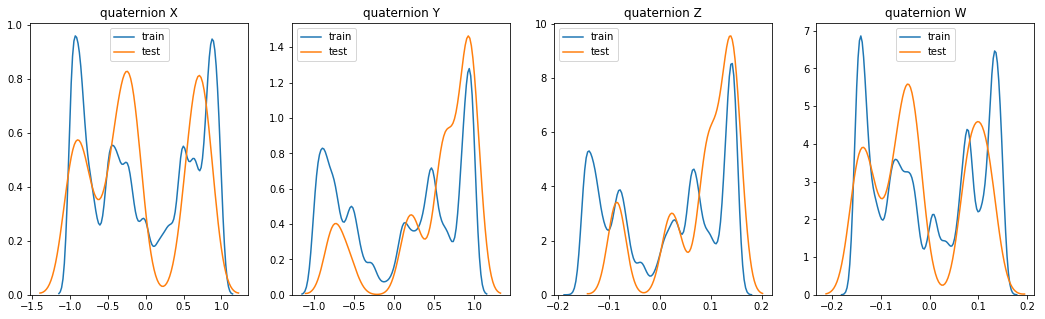

In [934]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('quaternion X')
sns.kdeplot(X_tra['norm_X'], ax=ax1, label="train")
sns.kdeplot(X_tes['norm_X'], ax=ax1, label="test")

ax2.set_title('quaternion Y')
sns.kdeplot(X_tra['norm_Y'], ax=ax2, label="train")
sns.kdeplot(X_tes['norm_Y'], ax=ax2, label="test")

ax3.set_title('quaternion Z')
sns.kdeplot(X_tra['norm_Z'], ax=ax3, label="train")
sns.kdeplot(X_tes['norm_Z'], ax=ax3, label="test")

ax4.set_title('quaternion W')
sns.kdeplot(X_tra['norm_W'], ax=ax4, label="train")
sns.kdeplot(X_tes['norm_W'], ax=ax4, label="test")

plt.show()

In [935]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [936]:
X_tra = fe_step1(X_tra)
X_tes = fe_step1(X_tes)
print (X_tra.shape)
X_tra.head()

(485120, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


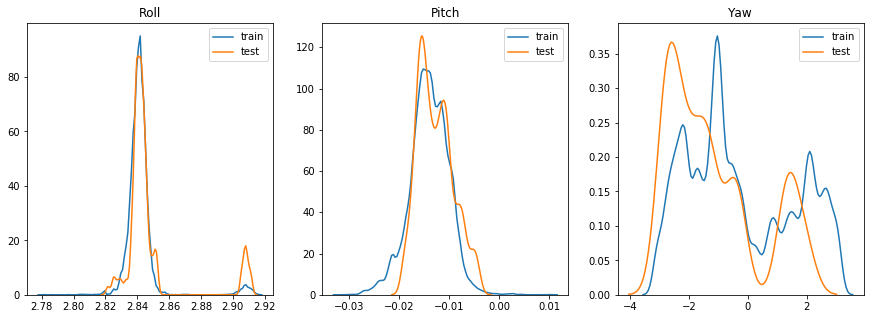

In [937]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.set_title('Roll')
sns.kdeplot(X_tra['euler_x'], ax=ax1, label="train")
sns.kdeplot(X_tes['euler_x'], ax=ax1, label="test")

ax2.set_title('Pitch')
sns.kdeplot(X_tra['euler_y'], ax=ax2, label="train")
sns.kdeplot(X_tes['euler_y'], ax=ax2, label="test")

ax3.set_title('Yaw')
sns.kdeplot(X_tra['euler_z'], ax=ax3, label="train")
sns.kdeplot(X_tes['euler_z'], ax=ax3, label="test")

plt.show()

In [938]:
X_tra.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


In [939]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [940]:
%%time
X_tra = feat_eng(X_tra)
X_tes = feat_eng(X_tes)
#print ("New features: ",data.shape)

CPU times: user 2min 28s, sys: 1.44 s, total: 2min 29s
Wall time: 2min 27s


In [941]:
X_t = X_tra[:3600]
X_v = X_tra[3600:]
Y_t = Y_tra[:3600]
Y_v = Y_tra[3600:]

In [942]:
'''
from sklearn import preprocessing
%matplotlib inline
le = preprocessing.LabelEncoder()

Y_tra['surface'] = le.fit_transform(Y_tra['surface'])
Y_tes['surface'] = le.fit_transform(Y_tes['surface'])
'''

"\nfrom sklearn import preprocessing\n%matplotlib inline\nle = preprocessing.LabelEncoder()\n\nY_tra['surface'] = le.fit_transform(Y_tra['surface'])\nY_tes['surface'] = le.fit_transform(Y_tes['surface'])\n"

In [943]:
#Y_tra = pd.DataFrame(Y_tra['surface'])
#Y_tes = pd.DataFrame(Y_tes['surface'])

Splitting data into train and test

In [944]:
'''
X_tra = pd.DataFrame(data[:3000][:])
X_tes = pd.DataFrame(data[3000:][:])
Y_tra = pd.DataFrame(target[:3000]['surface'])
Y_tes = pd.DataFrame(target[3000:]['surface'])
'''

"\nX_tra = pd.DataFrame(data[:3000][:])\nX_tes = pd.DataFrame(data[3000:][:])\nY_tra = pd.DataFrame(target[:3000]['surface'])\nY_tes = pd.DataFrame(target[3000:]['surface'])\n"

**3. Selection of an algorithm**

In this step we are going to check for the possible ML models we can use for this problem and pick the one which suites the best.

In [945]:
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

In [946]:
predicted = np.zeros((X_tes.shape[0],9))
measured= np.zeros((X_tra.shape[0]))
score = 0

In [947]:
'''
from sklearn.ensemble import RandomForestClassifier
import gc

for times, (trn_idx, val_idx) in enumerate(folds.split(X_tra.values,Y_tra['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #print(trn_idx)
    #print(val_idx)
    #print(times)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(X_tra.iloc[trn_idx],Y_tra['surface'][trn_idx])
    measured[val_idx] = model.predict(X_tra.iloc[val_idx])
    predicted += model.predict_proba(X_tes)/folds.n_splits
    #print(predicted.shape)
    score += model.score(X_tra.iloc[val_idx],Y_tra['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(X_tra.iloc[val_idx],Y_tra['surface'][val_idx])))

    importances = model.feature_importances_
    #print(len(importances))
    indices = np.argsort(importances)
    #print(indices)
    features = X_tra.columns
    #print(features)
    #print(len(features))
    
    if model.score(X_tra.iloc[val_idx],Y_tra['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()
    '''

'\nfrom sklearn.ensemble import RandomForestClassifier\nimport gc\n\nfor times, (trn_idx, val_idx) in enumerate(folds.split(X_tra.values,Y_tra[\'surface\'].values)):\n    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)\n    #print(trn_idx)\n    #print(val_idx)\n    #print(times)\n    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)\n    model.fit(X_tra.iloc[trn_idx],Y_tra[\'surface\'][trn_idx])\n    measured[val_idx] = model.predict(X_tra.iloc[val_idx])\n    predicted += model.predict_proba(X_tes)/folds.n_splits\n    #print(predicted.shape)\n    score += model.score(X_tra.iloc[val_idx],Y_tra[\'surface\'][val_idx])\n    print("Fold: {} score: {}".format(times,model.score(X_tra.iloc[val_idx],Y_tra[\'surface\'][val_idx])))\n\n    importances = model.feature_importances_\n    #print(len(importances))\n    indices = np.argsort(importances)\n    #print(indices)\n    features = X_tra.columns\n    #print(features)\n    #print(len(fea

In [948]:
sub = pd.read_csv('../input/career-con-2019/sample_submission.csv')
sub = sub[3796:]

In [949]:
sub['surface'] = predicted.argmax(axis=1)
sub = pd.DataFrame(sub['surface'])
sub.head()

,surface
3796,0
3797,0
3798,0
3799,0
3800,0


In [950]:
from sklearn.metrics import classification_report
di = classification_report(Y_tes, sub, output_dict=True)
print(di['accuracy'])

0.0


In [951]:
#sub['surface'] = le.inverse_transform(predicted.argmax(axis=1))
#sub.to_csv('submission.csv', index=False)
#sub.head()

In [952]:
'''
data.head()
data.shape
X_tra = data[:3400][:]
X_tes = data[3400:][:]
Y_tra = target[:3400]['surface']
Y_tes = target[3400:]['surface']
'''

"\ndata.head()\ndata.shape\nX_tra = data[:3400][:]\nX_tes = data[3400:][:]\nY_tra = target[:3400]['surface']\nY_tes = target[3400:]['surface']\n"

In [953]:
target[0:2]['surface']
X_tes.shape

(20, 276)

In [954]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [955]:
#transform = transforms.ToTensor()
#train_data = datasets.MNIST(root='data', train=True,
#                                   download=True, transform=transform)
#test_data = datasets.MNIST(root='data', train=False,
#                                  download=True, transform=transform)

In [956]:
X = torch.from_numpy(X_t.values)
y = torch.from_numpy(Y_t.values)
X_va = torch.from_numpy(X_v.values)
Y_va = torch.from_numpy(Y_v.values)
X_te = torch.from_numpy(X_tes.values)
y_te = torch.from_numpy(Y_tes.values)

In [957]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sklearn.datasets

In [958]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler() # normalization, x-mean/std
X=sc.fit_transform(X) # apply to data
X=torch.tensor(X) # convert numpy to torch tensor
#y=torch.tensor(y).unsqueeze(1) # add extra dim (768,) to (768,1)
y=torch.tensor(y) # add extra dim (768,) to (768,1)

X_va = sc.fit_transform(X_va) # apply to data
X_va=torch.tensor(X_va) # convert numpy to torch tensor
#y=torch.tensor(y).unsqueeze(1) # add extra dim (768,) to (768,1)
Y_va=torch.tensor(Y_va) # add extra dim (768,) to (768,1)

X_te = sc.fit_transform(X_te)
X_te = torch.tensor(X_te) # convert numpy to torch tensor
#y_te = torch.tensor(y_te).unsqueeze(1) # add extra dim (768,) to (768,1)
y_te = torch.tensor(y_te) # add extra dim (768,) to (768,1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [959]:
print(X.shape,X.dtype)
print(y.shape,y.dtype)
print(X_va.shape,X_va.dtype)
print(Y_va.shape,Y_va.dtype)
print(X_te.shape,X_te.dtype)
print(y_te.shape,y_te.dtype)

torch.Size([3600, 276]) torch.float64
torch.Size([3600, 1]) torch.int64
torch.Size([190, 276]) torch.float64
torch.Size([190, 1]) torch.int64
torch.Size([20, 276]) torch.float64
torch.Size([20, 1]) torch.int64


In [960]:
from torch.autograd import Variable
X=Variable(X) #Variable initialization
y=Variable(y)

X_va = Variable(X_va)
Y_va = Variable(Y_va)

X_te = Variable(X_te)
y_te = Variable(y_te)

In [961]:
'''
y_label = torch.zeros(2800,9)
j = 0
for i in y:
    y_label[j][i] = 1
    j+=1
    #print(k_labe[j][i])
print(y_label)
y_label = Variable(y_label)

y_test_label = torch.zeros(1010,9)
j=0
for i in y_te:
    y_test_label[j][i] = 1
    j += 1
print(y_test_label)
y_test_label = Variable(y_test_label)
'''

'\ny_label = torch.zeros(2800,9)\nj = 0\nfor i in y:\n    y_label[j][i] = 1\n    j+=1\n    #print(k_labe[j][i])\nprint(y_label)\ny_label = Variable(y_label)\n\ny_test_label = torch.zeros(1010,9)\nj=0\nfor i in y_te:\n    y_test_label[j][i] = 1\n    j += 1\nprint(y_test_label)\ny_test_label = Variable(y_test_label)\n'

In [962]:
from torch.utils.data import Dataset
class Dataset(Dataset):
  def __init__(self,x,y):
    self.x=x
    self.y=y
  
  def __getitem__(self,index):
    return self.x[index], self.y[index]
  
  def __len__(self):
    return len(self.x)

In [963]:
dataset=Dataset(X,y)
print(dataset.x.shape)
print(dataset.y.shape)

#dataset_test = Dataset(X_te, y_test_label)
#print(dataset_test.x.shape)
#print(dataset_test.y.shape)

torch.Size([3600, 276])
torch.Size([3600, 1])


In [964]:
train_loader= torch.utils.data.DataLoader(dataset=dataset, batch_size=50, shuffle=True) # load data
#test_loader= torch.utils.data.DataLoader(dataset=dataset_test, shuffle=True) # load data

In [965]:
class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.fc1 =torch.nn.Linear(X.shape[1],300)
    self.relu=nn.ReLU() 
    self.batchnorm1 = nn.BatchNorm1d(300)
    self.sigmoid=torch.nn.Sigmoid()
    self.fc2 =torch.nn.Linear(300,150) 
    self.batchnorm2 = nn.BatchNorm1d(150)
    self.fc3 =torch.nn.Linear(150,9)
    #self.batchnorm3 = nn.BatchNorm1d(100)
    #self.fc4 =torch.nn.Linear(100,9)
    #self.sigmoid=torch.nn.Sigmoid()
    self.softmax = nn.Softmax()

    
  def forward(self,x):
    out =self.fc1(x)
    out = self.batchnorm1(out)
    out =self.sigmoid(out)
    #out = self.relu(out)
    out =self.fc2(out)
    out = self.batchnorm2(out)
    #out =self.sigmoid(out)
    out = self.relu(out)
    out =self.fc3(out)
    #out = self.batchnorm3(out)
    #out = self.relu(out)
    #out =self.sigmoid(out)
    #out =self.fc4(out)
    #out= self.sigmoid(out)
    out = self.softmax(out)
    return out

In [966]:
net = Model()
#criterion =torch.nn.MSELoss(size_average=True)
criterion = torch.nn.CrossEntropyLoss(size_average=True)
optimizer =torch.optim.Adam(net.parameters(), lr=0.01)

/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [967]:
#a = torch.zeros(2800)
#y.squeeze().shape
#a = y
#y.shape
#a.shape
#y_label.shap

In [968]:
from sklearn.metrics import classification_report
num_epochs = 200
for epoch in range(num_epochs):
  data = 0
  for inputs, labels in train_loader:
    inputs = Variable(inputs.float())
    labels= Variable(labels.float())
    output = net(inputs)
    #print(torch.round(output))
    #print(output.argmax(1))
    optimizer.zero_grad()
    #print(output.argmax(1))
    #print(labels.squeeze())
    loss = criterion(output,labels.squeeze().long())
    #output = (output>0.5).float()
    #data += (output == labels).float().sum()
    data += classification_report(labels, output.argmax(1),output_dict=True)['accuracy']
    #data += (output.argmax(1) == labels.argmax(1)).float().sum()
    # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()
    loss.backward()
    optimizer.step()
    #print(output - labels)
  print(data/76)
  #output = (output>0.5).float()
  #print(output)
  #print(labels)
  #print(classification_report(labels, output))
  #data += (output == labels).float().sum()
  #print(correct)
  #print("Epoch {}/{}, loss:{:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs,loss.item(),data/2800*9))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.42131578947368425
0.45947368421052653
0.476842105263158
0.48973684210526314
0.5142105263157895
0.5171052631578944
0.5392105263157894
0.5484210526315788
0.5502631578947369
0.554473684210526
0.5692105263157895
0.5660526315789474
0.5763157894736841
0.5873684210526315
0.587894736842105
0.589736842105263
0.5947368421052631
0.5836842105263158
0.5805263157894736
0.5910526315789474
0.6010526315789472
0.616578947368421
0.6123684210526313
0.6099999999999999
0.6213157894736838
0.6239473684210527
0.6276315789473682
0.6376315789473681
0.623157894736842
0.6252631578947369
0.6307894736842106
0.6302631578947372
0.6328947368421052
0.6423684210526314
0.638421052631579
0.6307894736842105
0.6407894736842105
0.646578947368421
0.6371052631578947
0.645
0.6363157894736842
0.6378947368421052
0.636578947368421
0.6494736842105264
0.6502631578947367
0.6607894736842105
0.6760526315789475
0.6942105263157894
0.716842105263158
0.7278947368421053
0.7368421052631579
0.7336842105263157
0.7376315789473683
0.74447368421

In [969]:
'''
for inputs, labels in test_loader:
    inputs = Variable(inputs.float())
    labels= Variable(labels.float())
    output = net(inputs)
    #print(torch.round(output))
    #print(output.argmax(1))
    #print(labels)
    print(output)
    print(labels)
    output = output.argmax(1)
    
    optimizer.zero_grad()
    #print(labels.shape)
    loss = criterion(output,labels)
    # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()
    loss.backward()
    optimizer.step()
'''

'\nfor inputs, labels in test_loader:\n    inputs = Variable(inputs.float())\n    labels= Variable(labels.float())\n    output = net(inputs)\n    #print(torch.round(output))\n    #print(output.argmax(1))\n    #print(labels)\n    print(output)\n    print(labels)\n    output = output.argmax(1)\n    \n    optimizer.zero_grad()\n    #print(labels.shape)\n    loss = criterion(output,labels)\n    # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()\n    loss.backward()\n    optimizer.step()\n'

In [970]:
inputs = Variable(X_te.float())
labels= Variable(y_te.float())
output = net(inputs)
#output = (output>0.5).float()
#data += (output == labels).float().sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [971]:
output = (output>0.5).float()
data = (output.argmax(1) == labels).float().sum()

In [972]:
data/20

tensor(3.8000)

In [973]:
inputs = Variable(X_va.float())
labels= Variable(Y_va.float())
output = net(inputs)
pre_d = output.argmax(1).unsqueeze(1)
y_tru = labels

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [974]:
type(output)
di = classification_report(y_tru, pre_d, output_dict=True)
print(di['accuracy'])

0.8736842105263158


In [975]:
inputs = Variable(X_te.float())
labels= Variable(y_te.float())
output = net(inputs)
pre_d = output.argmax(1).unsqueeze(1)
y_tru = labels


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [976]:
type(output)
di = classification_report(y_tru, pre_d, output_dict=True)
print(di['accuracy'])

0.8


In [977]:
'''
class FeedForward(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(FeedForward, self).__init__()
    self.hidden=nn.Linear(input_size, hidden_size)
    self.out=nn.Linear(hidden_size,output_size)
  def forward(self, x):
    x =self.hidden(x)
    x= F.relu(x)
    x= self.out(x)
    return x
'''

'\nclass FeedForward(torch.nn.Module):\n  def __init__(self, input_size, hidden_size, output_size):\n    super(FeedForward, self).__init__()\n    self.hidden=nn.Linear(input_size, hidden_size)\n    self.out=nn.Linear(hidden_size,output_size)\n  def forward(self, x):\n    x =self.hidden(x)\n    x= F.relu(x)\n    x= self.out(x)\n    return x\n'

In [978]:
'''
network = FeedForward(input_size=276, hidden_size=500, output_size=9)
optimizer=torch.optim.SGD(network.parameters(), lr=0.02)
loss_function=torch.nn.CrossEntropyLoss()'''

'\nnetwork = FeedForward(input_size=276, hidden_size=500, output_size=9)\noptimizer=torch.optim.SGD(network.parameters(), lr=0.02)\nloss_function=torch.nn.CrossEntropyLoss()'

In [979]:
'''
plt.ion()
for epoch in range(10000):
  out=network(X)
  loss=loss_function(out,y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if epoch % 1000 ==0:
    max_predicted, prediction=torch.max(out,1)
    predicted_y= prediction.data.numpy()
    target_y=y.data.numpy()
    plt.scatter(x.data.numpy()[:,0],x.data.numpy()[:,1], s=40, c=predicted_y, lw=0)
    accuracy=(predicted_y==target_y).sum() / target_y.size
    plt.text(3,-1,'Accuracy={:.2f}'.format(accuracy), fontdict={'size':14})
    plt.pause(0.1)

plt.ioff()
plt.show()
'''  

"\nplt.ion()\nfor epoch in range(10000):\n  out=network(X)\n  loss=loss_function(out,y)\n  optimizer.zero_grad()\n  loss.backward()\n  optimizer.step()\n  \n  if epoch % 1000 ==0:\n    max_predicted, prediction=torch.max(out,1)\n    predicted_y= prediction.data.numpy()\n    target_y=y.data.numpy()\n    plt.scatter(x.data.numpy()[:,0],x.data.numpy()[:,1], s=40, c=predicted_y, lw=0)\n    accuracy=(predicted_y==target_y).sum() / target_y.size\n    plt.text(3,-1,'Accuracy={:.2f}'.format(accuracy), fontdict={'size':14})\n    plt.pause(0.1)\n\nplt.ioff()\nplt.show()\n"